In [1]:
# Example to show how underspecification can lead to lack of robustness in kernel land

In [122]:
%matplotlib notebook 
import functools 
import numpy as np
import cvxpy as cp

import tqdm
import multiprocessing

import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import roc_auc_score



In [165]:
# generate the training data
def get_data(n, py1, py1_y0, pflip):
    # generate the true labels 
    y0 = np.random.binomial(1, py1, (n, 1))
    y1 = py1_y0 * y0 + (1 - py1_y0)*(1 - y0)
    y1 = np.random.binomial(1, y1, (n, 1))
    
    print(f' proportion of water birds on water background {np.mean(y1[y0==1]):.3f}')
    print(f' proportion of land birds on water background {np.mean(y1[y0==0]):.3f}')

    # generate x 
    # TODO: does this really generate an exploitable "shortcut"?
    x_means = np.hstack([y0 * 2.0, y1 * 10.0])
    x = np.random.normal(x_means, np.ones_like(x_means))
    # introduce label noise
    flips0 = np.random.choice(range(n), size = int(pflip*n), replace = False)
    y0[flips0] = 1 - y0[flips0] 

    flips1 = np.random.choice(range(n), size = int(pflip*n), replace = False)
    y1[flips1] = 1 - y1[flips1] 

    y = np.hstack([y0, y1])

    return x, y 

x_tr, y_tr = get_data(100, 0.5, 0.5, 0.1)
x_sts, y_sts = get_data(100, 0.5, 0.5, 0.1)
x_dts, y_dts = get_data(100, 0.5, 0.9, 0.1)


 proportion of water birds on water background 0.569
 proportion of land birds on water background 0.500
 proportion of water birds on water background 0.510
 proportion of land birds on water background 0.612
 proportion of water birds on water background 0.957
 proportion of land birds on water background 0.148


In [166]:
def compute_mmd(sigma, x, auxiliary_labels):    
    x1 = x[auxiliary_labels == 1]
    x0 = x[auxiliary_labels == 0]

    pos_kernel = RBF(length_scale=sigma).__call__(x1, x1)
    neg_kernel = RBF(length_scale=sigma).__call__(x0, x0)
    pos_neg_kernel = RBF(length_scale=sigma).__call__(x1, x0)

    pos_kernel_mean = np.mean(pos_kernel)
    neg_kernel_mean = np.mean(neg_kernel)
    pos_neg_kernel_mean = np.mean(pos_neg_kernel)

    mmd_val = pos_kernel_mean + neg_kernel_mean - 2 * pos_neg_kernel_mean
    mmd_val = np.maximum(0.0, mmd_val)
    return mmd_val


In [167]:
# sigma0 = np.logspace(np.log10(0.01), np.log10(1000), 100)
# sigma1 = np.logspace(np.log10(0.01), np.log10(1000), 100)
sigma0 = np.linspace(0, 25, 50)
sigma1 = np.linspace(0, 25, 50)

sigma0[sigma0 < 0.001] = 0.001
sigma1[sigma1 < 0.001] = 0.001

sigma0, sigma1 = np.meshgrid(sigma0, sigma1)

In [168]:
sigma_mat = np.hstack([np.reshape(sigma0, (sigma0.size, 1)),
                       np.reshape(sigma1, (sigma1.size, 1))])

In [169]:

compute_mmd_for_data = functools.partial(compute_mmd, x=x_tr, auxiliary_labels = y_tr[:, 1])

In [170]:
mmd_val = np.apply_along_axis(compute_mmd_for_data, 1, sigma_mat)
mmd_val = np.reshape(mmd_val, sigma0.shape)

In [171]:
def sigmoid(x):
	return 1 / (1 + np.exp(-x))


class KernelSlabs():
	""" Kernel version of our model """

	def __init__(self, kernel, sigma, C, **unused_kwargs):

		""" Constructor """
		if ((kernel != 'rbf') and (kernel != 'poly')):
			raise NotImplementedError("Incorrect kernel string. Pick from rbf and poly")
		self.kernel = kernel
		self.sigma = sigma
		self.C = C

	def fit(self, x, labels, w=None):
		""" Fits the main function """

		# -- fit kernel
		if self.kernel == 'rbf':
			self.x_tr = x.copy()
			self.kernel_fit = lambda x_ts: RBF(length_scale=self.sigma).__call__(x_ts,
				self.x_tr)
		elif self.kernel == 'poly':
			self.kernel_fit = lambda x: np.hstack(
				[x**i for i in range(1, int(self.sigma) + 1)])

		x = self.kernel_fit(x)
		y = labels[:, 0]

		# -- setup opt problem
		n, d = x.shape[0], x.shape[1]
		if w is None:
			w = np.ones(n) / n

		bf = cp.Variable(d)
		individual_log_like = cp.multiply(y, x @ bf) - cp.logistic(x @ bf)
		log_likelihood = cp.sum(cp.multiply(w, individual_log_like))
		problem = cp.Problem(cp.Maximize(log_likelihood - self.C * cp.norm(bf, 2)))
		try: 
			problem.solve()
			self.bf = bf.value
			self.obj_value = problem.value 

		except: 
			print(f'Sigma {self.sigma}, C {self.C}')            
			self.bf = np.zeros(d)
			self.obj_value = 1e5


	def get_objective_value(self):
		return self.obj_value

	def predict(self, x):
		""" Predicts lower and upper bounds at a point x """
		x = self.kernel_fit(x)

		yh = np.dot(x, self.bf)
		yh = sigmoid(yh)

		return yh

In [172]:
def train_and_get_metrics(sigma, data_tr, data_same, data_different):
    x_tr, y_tr = data_tr
    model = KernelSlabs(kernel='rbf', sigma=sigma, C=0.0001)
    model.fit(x_tr, y_tr)
    obj_value = model.get_objective_value()
    
    x_sts, y_sts = data_same 
    y_sts = y_sts[:, 0]
    yh_sts = model.predict(x_sts)
    acc_sts = (yh_sts > 0.5) * 1.0
    acc_sts = np.mean(acc_sts == y_sts)
    auc_sts = roc_auc_score(y_sts, yh_sts)
    
    x_dts, y_dts = data_different 
    y_dts = y_dts[:, 0]
    yh_dts = model.predict(x_dts)
    acc_dts = (yh_dts > 0.5) * 1.0
    acc_dts = np.mean(acc_dts == y_dts)
    auc_dts = roc_auc_score(y_dts, yh_dts)
    return obj_value, acc_sts, auc_sts, acc_dts, auc_dts 


In [173]:
get_obj_for_data = functools.partial(train_and_get_metrics,
                                     data_tr=(x_tr, y_tr),
                                     data_same=(x_sts, y_sts),
                                     data_different=(x_dts, y_dts))

In [174]:
NJOBS = 30

if NJOBS > 0:
    pool = multiprocessing.Pool(NJOBS)
    sigma_list = [sigma_mat[i] for i in range(sigma_mat.shape[0])]

    loss_val = []
    acc_same = []
    auc_same = []
    acc_diff = []
    auc_diff = []
    
    for res in tqdm.tqdm(pool.imap(get_obj_for_data, sigma_list),
                       total=len(sigma_list)):
        obj_value, acc_sts, auc_sts, acc_dts, auc_dts = res 
        loss_val.append(obj_value)
        acc_same.append(acc_sts)
        auc_same.append(auc_sts)
        acc_diff.append(acc_dts)
        auc_diff.append(auc_dts)
        
        
else: 
    loss_val = np.apply_along_axis(get_obj_for_data, 1, sigma_mat)
    loss_val = np.reshape(loss_val, sigma0.shape)

 42%|████▏     | 1040/2500 [00:16<00:27, 52.44it/s]/data/ddmg/users/mmakar/shared_conda/anaconda3/envs/slabs/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 46%|████▌     | 1149/2500 [00:17<00:23, 58.09it/s]/data/ddmg/users/mmakar/shared_conda/anaconda3/envs/slabs/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/data/ddmg/users/mmakar/shared_conda/anaconda3/envs/slabs/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 2500/2500 [00:38<00:00, 64.91it/s]


In [175]:
loss_val = np.vstack(loss_val)
loss_val = np.reshape(loss_val, sigma0.shape)

acc_same = np.vstack(acc_same)
acc_same = np.reshape(acc_same, sigma0.shape)

auc_same = np.vstack(auc_same)
auc_same = np.reshape(auc_same, sigma0.shape)

acc_diff = np.vstack(acc_diff)
acc_diff = np.reshape(acc_diff, sigma0.shape)

auc_diff = np.vstack(auc_diff)
auc_diff = np.reshape(auc_diff, sigma0.shape)


In [176]:
# sigma0_ticks = np.arange(0, 100, 1)
# sigma1_ticks = np.arange(0, 100, 1)

# sigma0_ticks, sigma1_ticks = np.meshgrid(sigma0_ticks, sigma1_ticks)
# tick_labs = [f'{x:.2f}' for x in np.logspace(np.log10(0.01), np.log10(1000), 100)]

<IPython.core.display.Javascript object>


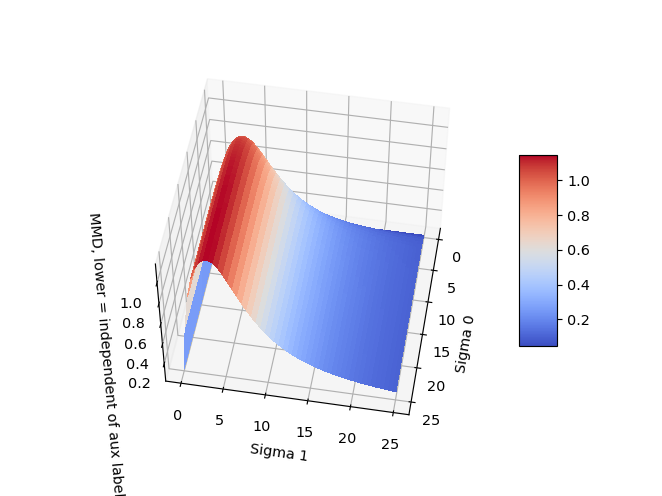

In [177]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(sigma0, sigma1, mmd_val, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel("Sigma 0")
ax.set_ylabel("Sigma 1")

ax.set_zlabel("MMD, lower = independent of aux label")


plt.show()

# conclusion --> you can get independence by setting sigma 1 to be low, and setting sigma 0 to be whatever 
# if sigma1 is high, even low values of sigma 0 give high mmd 
# meaning it's impossible to achieve low mmd with high sigma 1 (for low enough sigma 0)
# ROUGHLY?

In [178]:
# loss_val[loss_val >= 1e5] = 10

<IPython.core.display.Javascript object>


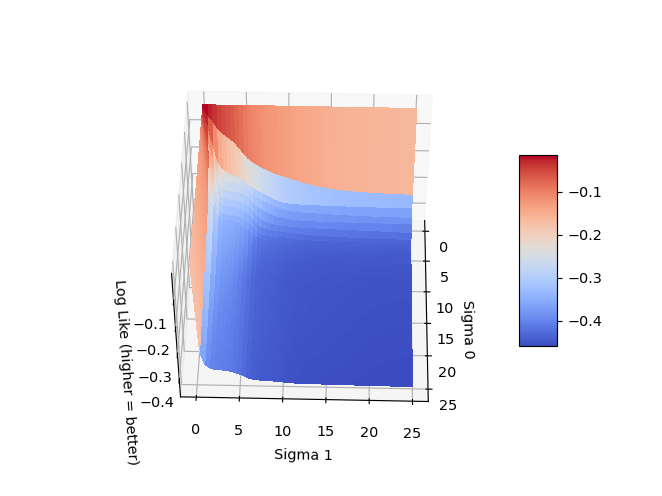

In [179]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(sigma0, sigma1, loss_val, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel("Sigma 0")
ax.set_ylabel("Sigma 1")
ax.set_zlabel("Log Like (higher = better)")


plt.show()


In [180]:
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# surf = ax.plot_surface(sigma0_ticks, sigma1_ticks, acc_same, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

# # Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)
# ax.set_xlabel("Sigma 0")
# ax.set_ylabel("Sigma 1")
# ax.set_zlabel("Accuracy (same dist)")


# plt.show()


In [181]:
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# surf = ax.plot_surface(sigma0_ticks, sigma1_ticks, acc_diff, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

# # Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)
# ax.set_xlabel("Sigma 0")
# ax.set_ylabel("Sigma 1")
# ax.set_zlabel("Accuracy (diff dist)")


# plt.show()


<IPython.core.display.Javascript object>


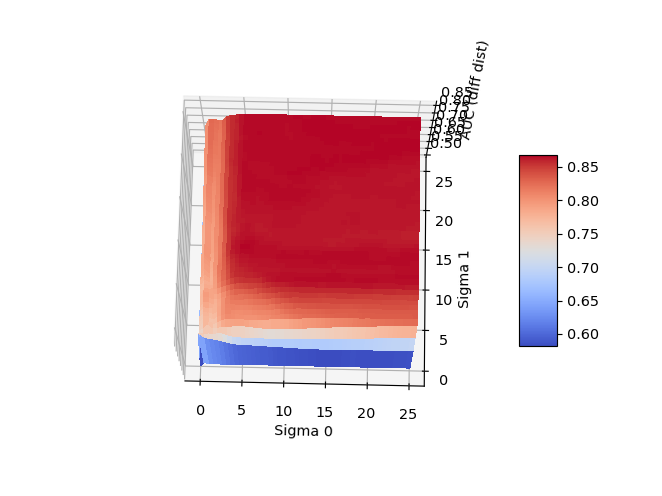

In [182]:
fig = plt.figure()
ax = fig.gca(projection='3d')

auc_samec = auc_same.copy()

auc_samec[auc_samec < 0.9] =  0.9


surf = ax.plot_surface(sigma0, sigma1, auc_same, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel("Sigma 0")
ax.set_ylabel("Sigma 1")
ax.set_zlabel("AUC (diff dist)")


plt.show()

<IPython.core.display.Javascript object>


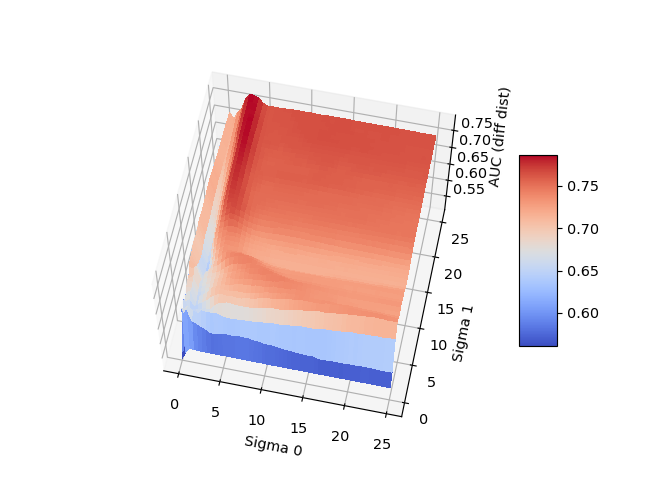

In [183]:
fig = plt.figure()
ax = fig.gca(projection='3d')

auc_diffc = auc_diff.copy()
auc_diffc[auc_diffc < 0.9] =  0.9

surf = ax.plot_surface(sigma0, sigma1, auc_diff, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel("Sigma 0")
ax.set_ylabel("Sigma 1")
ax.set_zlabel("AUC (diff dist)")


plt.show()

In [ ]:
plt.clf()

In [41]:
acc_diff

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])